This notebook will specifically use data from the Allen Insitute for Neural Dynamics and show how we can leverage CEBRA to analyse our in-house data. Here we will check if we can distinguish right vs left trials in the foraging task data.

In [8]:
import sys
import os # my addtion

import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import cebra.data
import torch
import cebra.integrations
import cebra.datasets
from cebra import CEBRA
import torch
import pickle
import utils
import sklearn.linear_model


from matplotlib.collections import LineCollection
import pandas as pd

## A. Load the Data

Here we load data from the Fibre Photometry pipeline of 4 Neuromodulators (DA, 5HT, ACh, NE) recorded in the Nucleus Acumbens region. The main neural data will be in the form of dF_F traces of these 4 Neuromodulators (NMs). These will be stored in a 2D array, 'all_nms'.

In [9]:
pd.__version__

'2.0.0'

In [10]:
#pip install pandas==2.0.0

In [11]:
# load the dataframe that contains data from 1 session
df_trials_ses = pickle.load(open('/Users/brian.gitahi/Desktop/AIND/CEBRA/Git/CEBRA-Demo/data/CO data/df.pkl', "rb"))

In [12]:
df_trials_ses.columns

Index(['bit_code', 'ses_idx', 'rpe', 'left_action_value', 'right_action_value',
       'licks L', 'licks R', 'Lick L (raw)', 'Lick R (raw)', 'trial', 'reward',
       'choice', 'go_cue_absolute_time', 'go_cue', 'choice_time',
       'reward_time', 'onset', 'NM', 'NM_name', 'region', 'last_value_NM',
       'overlap_index', 'NM_no_overlap', 'bins_mids', 'bins_mids_no_overlap'],
      dtype='object')

In [13]:
df_trials_ses[['rpe']][0:1765].describe()

,rpe
count,1717.000000
mean,0.056188
std,0.521106
min,-0.899843
25%,-0.331301
50%,-0.069068
75%,0.554228
max,1.000000


NB: There's 1765 trials in this data frame (the indices are repeated over each neuromodulator)
all information is in the first 1765 rows so we'll consider those

In [14]:
n_trials = 1765

In [15]:
# download the dictionary containing the traces
traces = pickle.load(open('/Users/brian.gitahi/Desktop/AIND/CEBRA/Git/CEBRA-Demo/data/CO data/traces.pkl', "rb"))

In [16]:
# load the trace times
trace_times = np.load('/Users/brian.gitahi/Desktop/AIND/CEBRA/Git/CEBRA-Demo/data/CO data/Trace times.npy', allow_pickle=True)

In [17]:
# get the choice time 
choice_times = df_trials_ses['choice_time'][0:n_trials].to_numpy()

In [18]:
# Combine the traces into one 2D array
all_nms = np.array([traces[trace] for trace in traces.keys()])
all_nms = np.transpose(all_nms)

# change it to an array of floats (previously it was an array of object datatype)
all_nms_new = all_nms.astype(np.float64)
all_nms_new.shape


(218572, 4)

In [19]:
all_nms.shape

(218572, 4)

In [20]:
# change it to an array of floats (previously it was an array of object datatype)
all_nms_new = all_nms.astype(np.float64)
all_nms_new.shape

(218572, 4)

In [21]:
# convert it to a tensor (this is probably not necessary but we want it to be as close to the inputs in the previous notebook)
all_nms_tensor = torch.from_numpy(all_nms_new)
all_nms_tensor.shape

torch.Size([218572, 4])

## B. Format data and create the behavioural/auxiliary variables

Now let's format the data. We want to view the data in a 1 second window around the choice time at each trial in the session. The hope is that this will make it easy to identify the trials where it chose to lick left and those where it chose to lick right.

Each trial will be labelled as rewarded/unrewarded and this will be the behavioural variable we use for this analysis.

In [22]:
rpe_labels = df_trials_ses['rpe'][0:1765].to_numpy()
rpe_labels.shape

(1765,)

In [23]:
np.unique(np.isnan(rpe_labels),return_counts=True)

(array([False,  True]), array([1717,   48]))

In [24]:
df_trials_ses['rpe'].iloc[47]

0.36285199999999995

In [25]:
# Make a function to format the NM data into a 1s window around the choice

def format_data(neural_data, df, trace_times_, choice_times_ , window=None , window_size=10, n_trials=1765):

    # define the number of trials where the mouse made a choice
    n_choice_trials = np.unique(np.isnan(choice_times_),return_counts=True)[1][0]

    # list to hold all the 1s windows
    n_data_window = []

    # list to hold the rpe values
    rpe_labels_ = []

    reward_labels = []


    # loop over all trials
    for i in range(0,n_trials):

        # skip trials where the animal didn't make a choice (null choice time)
        if np.isnan(choice_times_[i]):
            continue

        # find the index of the closest time to the choice time in the trace_times array 
        idx = np.abs(trace_times_ - choice_times_[i]).argmin()

        # take the previous 10 and/or the next 10 values of the NM data at these indices - 1s window
        if window =='before':
            n_data_window.append(neural_data[idx-10:idx])

        if window == 'after':
            n_data_window.append(neural_data[idx:idx+10])

        if window == None:
            n_data_window.append(neural_data[idx-10:idx+10])

        # label the timepoints as rewarded or unrewarded
        if df['reward'].iloc[i]:
            # new trial label
            reward_labels.append(1)

        elif df['reward'].iloc[i]==False:
            # new trial label
            reward_labels.append(0)

        # get the rpe values at each trial
        rpe_labels_.append(df['rpe'].iloc[i])

    # stack the nm data for each trial
    nms_HD = np.stack(n_data_window).reshape((n_choice_trials,-1))
    # format it into a tensor
    nms_HD = torch.from_numpy(nms_HD.astype(np.float64))
    print("neural tensor shape: ", nms_HD.shape)

    # convert labels to arrays
    rpe_labels_ = np.array(rpe_labels_)
    print("rpe labels shape:", rpe_labels_.shape)
    reward_labels = np.array(reward_labels)
    print("reward labels shape:", reward_labels.shape)


    return nms_HD, reward_labels, rpe_labels_

In [26]:
formatted_nms, reward_labels, rpe_labels_ = format_data(all_nms,df=df_trials_ses,trace_times_=trace_times, choice_times_=choice_times)

neural tensor shape:  torch.Size([1717, 80])
rpe labels shape: (1717,)
reward labels shape: (1717,)


In [27]:
rewarded, unrewarded = utils.define_label_classes(reward_labels)

Out of the 1765 trials in the session, this particular mouse made a choice in 1717 of them. The NM data is organized such that we have 20 timesteps for each of the 4 neuromodulators in this 1 second window.

## C. Build and train the CEBRA model then compute embeddings

In [28]:
t_embed, b_embed = utils.build_train_compute(formatted_nms, rpe_labels_)

pos:  1.0449 neg:  2.8355 total:  3.8803 temperature:  1.0000: 100%|██████████| 2000/2000 [00:59<00:00, 33.67it/s]
pos:  0.6855 neg:  5.4085 total:  6.0940 temperature:  1.0000: 100%|██████████| 2000/2000 [00:58<00:00, 34.11it/s]


# D. Analysis

In [29]:
# get auc scores
mean_scores, errors = utils.get_auc([t_embed, b_embed], trial_labels=reward_labels)
mean_scores

[0.49912434860078836, 0.89785694235956]

In [36]:
# define a function to view the embeddings
def view(time_embedding, behaviour_embedding, labels, label_classes, size=5):
 
    # create a figure and make the plots
    fig = plt.figure(figsize=(17,8))
    gs = gridspec.GridSpec(1, 2, figure=fig)


    ax81 = fig.add_subplot(gs[0,0], projection='3d')
    ax82 = fig.add_subplot(gs[0,1], projection='3d')
    
    for ax in [ax81,ax82]:
        ax.set_xlabel("latent 1", labelpad=0.001, fontsize=13)
        ax.set_ylabel("latent 2", labelpad=0.001, fontsize=13)
        ax.set_zlabel("latent 3", labelpad=0.001, fontsize=13)

        # Hide X and Y axes label marks
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.yaxis.set_tick_params(labelleft=False)
        ax.zaxis.set_tick_params(labelright=False)

        # Hide X and Y axes tick marks
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])


    # colour maps
    colours = ['cool', 'plasma', 'spring']

    # plot the time embedding 
    cebra.plot_embedding(embedding=time_embedding[label_classes[0],:], embedding_labels=labels[label_classes[0]],ax=ax81, markersize=size, title='Time embedding', cmap=colours[0])
    cebra.plot_embedding(embedding=time_embedding[label_classes[1],:], embedding_labels=labels[label_classes[1]],ax=ax81, markersize=size, title='Time embedding, AUC: {}'.format(np.round(mean_scores[0],2)), cmap=colours[1])


    # plot the behaviour embedding 
    cebra.plot_embedding(embedding=behaviour_embedding[label_classes[0],:], embedding_labels=labels[label_classes[0]],ax=ax82, markersize=size, title='Behaviour embedding', cmap=colours[0],)
    cebra.plot_embedding(embedding=behaviour_embedding[label_classes[1],:], embedding_labels=labels[label_classes[1]],ax=ax82,markersize=size, title='Behaviour embedding, AUC: {}'.format(np.round(mean_scores[1],2)),  cmap=colours[1])

    gs.tight_layout(figure=fig)

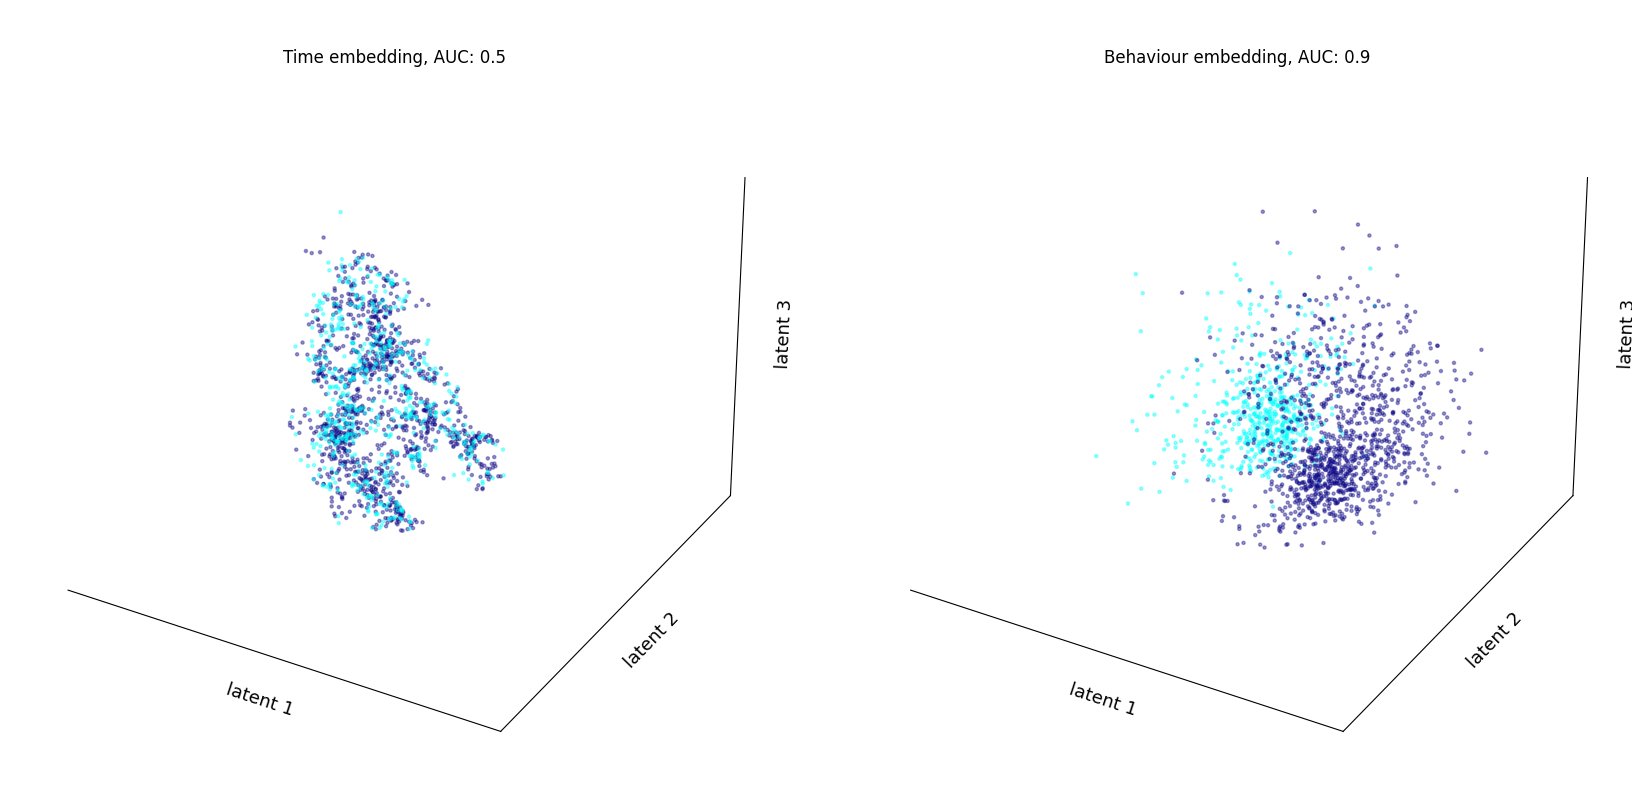

In [37]:
view(t_embed, b_embed, reward_labels, [rewarded,unrewarded])

## Labelling the Colours on the embeddings

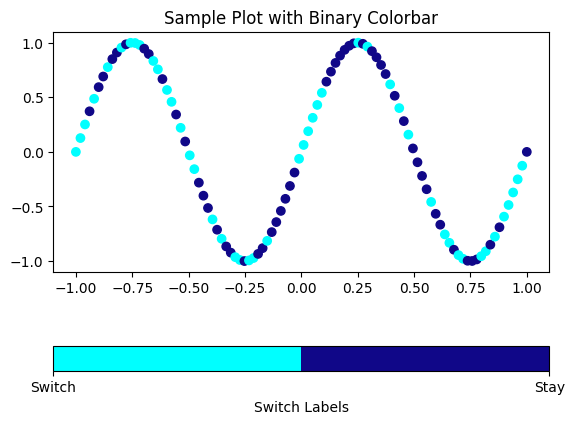

In [77]:
import matplotlib.colors as mcolors

# Sample data for the plot
x = np.linspace(-1, 1, 100)
y = np.sin(x * 2 * np.pi)

# Binary labels
labels = np.random.choice([0, 1], size=100)

# Define specific colors
cool_color = plt.cm.cool(0)  # Light blue end of the 'cool' colormap
plasma_color = plt.cm.plasma(1)  # Dark purple end of the 'plasma' colormap

# Create a custom colormap
cmap = mcolors.ListedColormap([cool_color, plasma_color])

# Create the plot
fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=labels, cmap=cmap)
ax.set_title('Sample Plot with Binary Colorbar')

# Create a custom colorbar

# cbar = plt.colorbar(scatter, ax=ax, ticks=[0, 1])
# cbar.set_label('Reward Labels')
# cbar.ax.set_yticklabels(['Rewarded', 'Unrewarded'])  # Custom labels


#Create a custom colorbar at the bottom
cbar = plt.colorbar(scatter, ax=ax, orientation='horizontal', pad=0.2)
cbar.set_label('Switch Labels')
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['Switch', 'Stay'])  # Custom labels

# Show the plot
plt.show()

In [73]:
import matplotlib.colors as mcolors


def colour_labels(labels=['Rewarded', 'Unrewarded'],orient='vertical', type='Reward'):
    # Sample data for the plot
    x = np.linspace(-1, 1, 100)
    y = np.sin(x * 2 * np.pi)

    # Binary labels
    labels = np.random.choice([0, 1], size=100)

    # Define specific colors
    cool_color = plt.cm.cool(0)  # Light blue end of the 'cool' colormap
    plasma_color = plt.cm.plasma(1)  # Dark purple end of the 'plasma' colormap

    # Create a custom colormap
    cmap = mcolors.ListedColormap([cool_color, plasma_color])

    # Create the plot
    fig, ax = plt.subplots()
    scatter = ax.scatter(x, y, c=labels, cmap=cmap)
    ax.set_title('Sample Plot with Binary Colorbar')

    # Create a custom colorbar
    if orient=='horizontal':
        # Create a custom colorbar at the bottom
        cbar = plt.colorbar(scatter, ax=ax, orientation='horizontal', pad=0.2)
        cbar.set_label(f'{type} Labels')
        cbar.set_ticks([0, 1])
        cbar.set_ticklabels([f'{labels[0]}', f'{labels[1]}'])  # Custom labels    
        plt.show()

    elif orient=='vertical':
        cbar = plt.colorbar(scatter, ax=ax, ticks=[0, 1])
        cbar.set_label(f'{type} Labels')
        cbar.ax.set_yticklabels([f'{labels[0]}', f'{labels[1]}'])  # Custom labels
        plt.show()

    # Show the plot
    

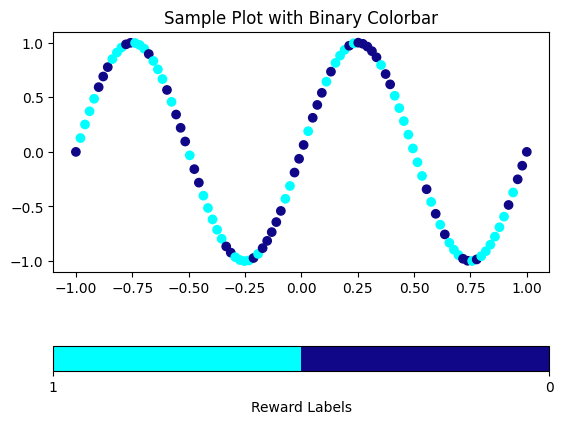

In [74]:
colour_labels(orient='horizontal')

From this pair of embeddings we can see that there is a clustering of the left (light blue) and right (purple) trials when we use CEBRA behaviour. 
This confirms to us that the rpe and the presence/absence of reward in the trial are related, because we can distinguish two clusters (rewarded/unrewarded) in the embedding produced when we use the rpe as the behaviour labels

Now let's colour the embeddings with the continuous rpe values to see whether we can still distinguish the trials based on this. (future idea: tracking linear separability in CEBRA embeddings)

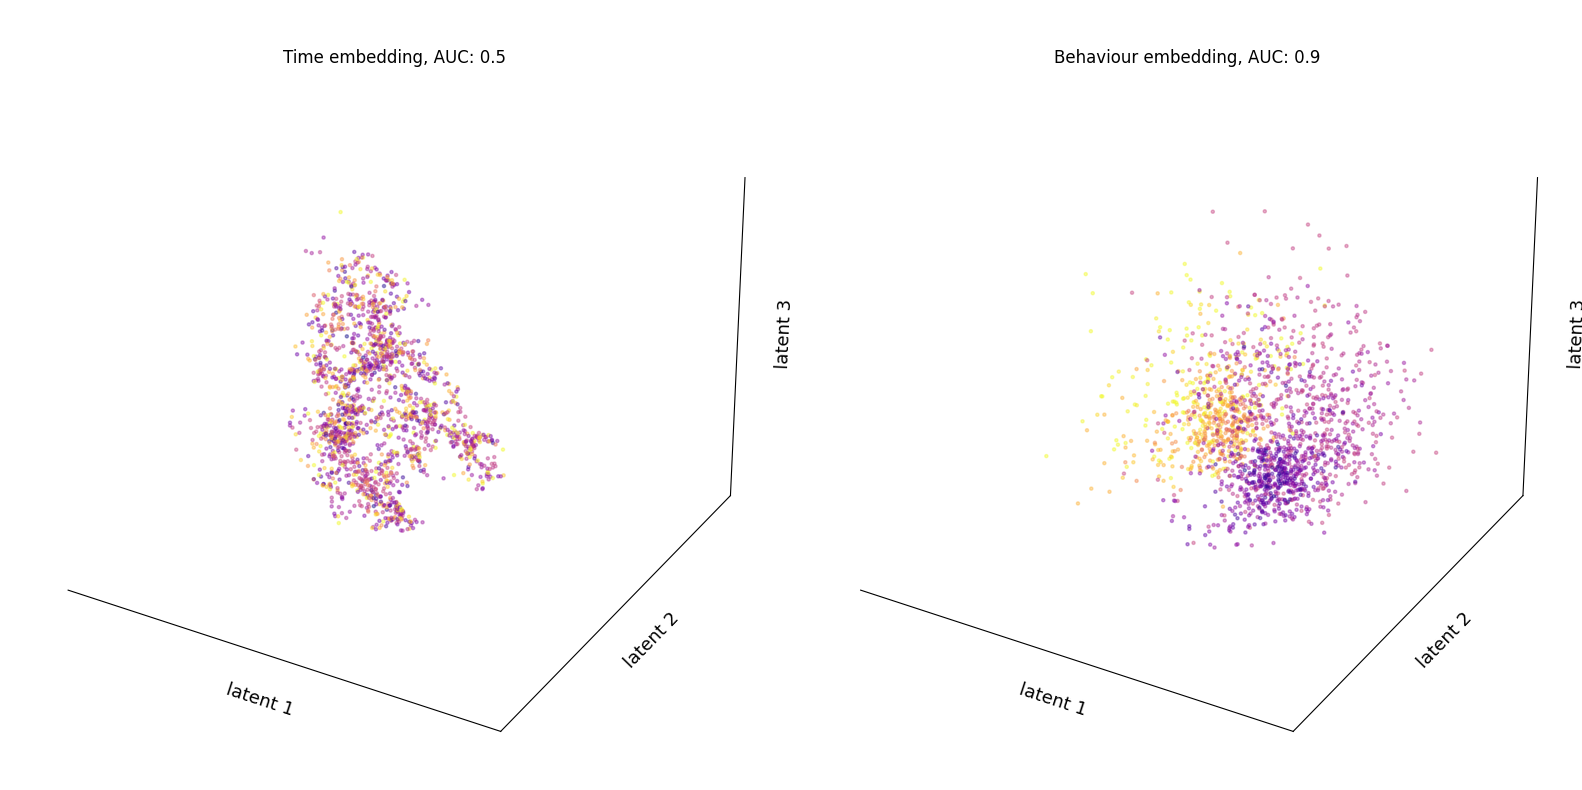

In [38]:
# now colour the embeddings with the continuous rpe values
# create a figure and make the plots
fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(1, 2, figure=fig)


ax81 = fig.add_subplot(gs[0,0], projection='3d')
ax82 = fig.add_subplot(gs[0,1], projection='3d')

for ax in [ax81,ax82]:
    ax.set_xlabel("latent 1", labelpad=0.001, fontsize=13)
    ax.set_ylabel("latent 2", labelpad=0.001, fontsize=13)
    ax.set_zlabel("latent 3", labelpad=0.001, fontsize=13)

    # Hide X and Y axes label marks
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.yaxis.set_tick_params(labelleft=False)
    ax.zaxis.set_tick_params(labelright=False)

    # Hide X and Y axes tick marks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

# colour maps
colours = ['cool', 'plasma', 'spring']

# plot the time embedding 
cebra.plot_embedding(embedding=t_embed, embedding_labels=rpe_labels_,ax=ax81, markersize=5, title='Time embedding, AUC: {}'.format(np.round(mean_scores[0],2)), cmap=colours[1])

# plot the behaviour embedding 
cebra.plot_embedding(embedding=b_embed, embedding_labels=rpe_labels_,ax=ax82,markersize=5, title='Behaviour embedding, AUC: {}'.format(np.round(mean_scores[1],2)),  cmap=colours[1])

gs.tight_layout(figure=fig)

In [33]:
df_trials_ses[['rpe']][0:1765].describe()

,rpe
count,1717.000000
mean,0.056188
std,0.521106
min,-0.899843
25%,-0.331301
50%,-0.069068
75%,0.554228
max,1.000000


In [67]:
np.random.randn(1,10)

array([[-1.18159448, -0.34906747,  0.27290081,  0.54490017, -0.4503233 ,
         1.4706124 ,  0.38218156, -0.55261851,  0.09231901, -0.44391165]])

In [27]:
np.random.rand(100, 100)

array([[0.56492004, 0.24588254, 0.52314992, ..., 0.98698149, 0.70952654,
        0.91750891],
       [0.0310917 , 0.05607651, 0.92196914, ..., 0.77852463, 0.23778507,
        0.00484525],
       [0.26393179, 0.58129858, 0.36654679, ..., 0.27961607, 0.62427402,
        0.79449548],
       ...,
       [0.95380453, 0.75893434, 0.53110149, ..., 0.2678157 , 0.55295125,
        0.84627794],
       [0.0783882 , 0.05809211, 0.3263405 , ..., 0.48889273, 0.81026305,
        0.04436153],
       [0.86615635, 0.31242755, 0.41605209, ..., 0.63314169, 0.56907726,
        0.27755343]])

In [3]:
np.random.randn(1000, 1000)


array([[ 0.36728582, -0.4566282 ,  1.25137734, ..., -0.23176569,
         0.6868533 , -0.77122334],
       [-1.29551026,  0.56291302,  0.15111677, ...,  1.85936354,
         0.04794616, -0.70304218],
       [ 0.08059689, -1.87995538,  0.57721049, ...,  0.34198888,
        -0.39362759,  1.72069965],
       ...,
       [ 0.49704329,  0.62221943,  0.34735553, ...,  0.62260159,
        -0.87549921,  1.7640173 ],
       [ 1.10987234,  0.31514221, -1.82655211, ...,  0.15607267,
        -0.85550735,  0.51281438],
       [-1.08383079, -1.35674057, -1.19228497, ...,  0.22075062,
        -1.68939582,  0.37227901]])

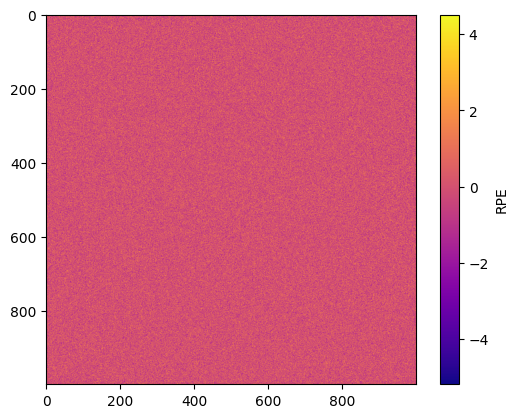

In [2]:
data = np.random.randn(1000, 1000)
fig, ax = plt.subplots()
cax = ax.imshow(data, cmap='plasma')
cbar = fig.colorbar(cax, ax=ax, label='RPE')



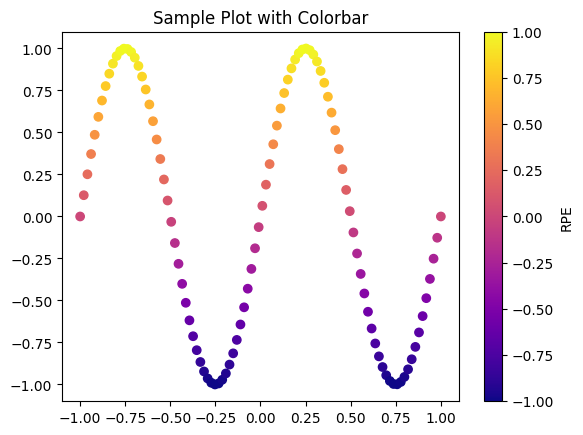

In [7]:

# Sample data for the plot
# Sample data for the plot
x = np.linspace(-1, 1, 100)
y = np.sin(x * 2 * np.pi)
colors = y

# Create the plot
fig, ax = plt.subplots()  # Create a figure and an axes
scatter = ax.scatter(x, y, c=colors, cmap='plasma', vmin=-1, vmax=1)
ax.set_title('Sample Plot with Colorbar')

# Create a colorbar
cbar = plt.colorbar(scatter, ax=ax)  # Associate colorbar with the axes
cbar.set_label('RPE')

# Show the plot
plt.show()

## Individual NMs

Now let's see how well the individual NMs capture the presence/absence of reward.

In [29]:
individual_nms = utils.individual_datasets(traces_=traces)

shape of formatted array: (218572, 1)
shape of formatted array: (218572, 1)
shape of formatted array: (218572, 1)
shape of formatted array: (218572, 1)


In [30]:
b_embeds, t_embeds, t_labels, [positive, negative] = utils.nm_analysis_2(individual_nms, df_trials_ses, trace_times, choice_times,title=" ",label='rpe')

neural tensor shape:  torch.Size([1717, 20])
reward labels shape:  (1717,)
choice labels shape:  (1717,)
rpe labels shape: (1717,)


pos:  0.6089 neg:  4.4741 total:  5.0830 temperature:  1.0000: 100%|██████████| 2000/2000 [00:54<00:00, 36.60it/s]
pos:  0.5469 neg:  5.5907 total:  6.1376 temperature:  1.0000: 100%|██████████| 2000/2000 [00:57<00:00, 34.57it/s]


COMPLETED ANALYSIS OF NM 0
neural tensor shape:  torch.Size([1717, 20])
reward labels shape:  (1717,)
choice labels shape:  (1717,)
rpe labels shape: (1717,)


pos:  0.8756 neg:  3.9498 total:  4.8254 temperature:  1.0000: 100%|██████████| 2000/2000 [00:52<00:00, 37.83it/s]
pos:  0.5433 neg:  5.5368 total:  6.0801 temperature:  1.0000: 100%|██████████| 2000/2000 [01:02<00:00, 31.81it/s]


COMPLETED ANALYSIS OF NM 1
neural tensor shape:  torch.Size([1717, 20])
reward labels shape:  (1717,)
choice labels shape:  (1717,)
rpe labels shape: (1717,)


pos:  0.8023 neg:  4.9167 total:  5.7190 temperature:  1.0000: 100%|██████████| 2000/2000 [00:56<00:00, 35.18it/s]
pos:  0.3936 neg:  5.7690 total:  6.1626 temperature:  1.0000: 100%|██████████| 2000/2000 [00:59<00:00, 33.39it/s]


COMPLETED ANALYSIS OF NM 2
neural tensor shape:  torch.Size([1717, 20])
reward labels shape:  (1717,)
choice labels shape:  (1717,)
rpe labels shape: (1717,)


pos:  0.4710 neg:  4.8860 total:  5.3570 temperature:  1.0000: 100%|██████████| 2000/2000 [00:53<00:00, 37.23it/s]
pos:  0.4560 neg:  5.7016 total:  6.1575 temperature:  1.0000: 100%|██████████| 2000/2000 [00:54<00:00, 36.59it/s]

COMPLETED ANALYSIS OF NM 3


In [31]:
len(b_embeds)

4

In [32]:
np.unique(reward_labels)

array([0, 1])

In [33]:
reward_labels.shape

(1717,)

In [34]:
means, sds = utils.get_auc(b_embeds, reward_labels)

In [35]:
means

[0.8699428843407901, 0.8825795713884718, 0.5, 0.5196022345891456]

In [36]:
len(b_embeds)

4

In [37]:
# first make function to make the plots given a list of embeddings
def plot4_embeddings(embeddings, labels , l_class, means=None, titles=['DA only', 'NE only', '5HT only', 'ACh only'], t=""):

    # number of plots
    n_plots = len(embeddings)

    n_columns = 2
    n_rows = n_plots//n_columns

    # create axis
    fig = plt.figure(figsize=(8,4*2))
    gs = gridspec.GridSpec(2, 2, figure=fig)

    # colour 
    c = ['cool','plasma','pink','winter']

    for i, embed in enumerate(embeddings):

        # create the axes
        ax = fig.add_subplot(gs[i // n_columns, i%n_columns], projection='3d')

        ax.set_xlabel("latent 1", labelpad=0.001, fontsize=13)
        ax.set_ylabel("latent 2", labelpad=0.001, fontsize=13)
        ax.set_zlabel("latent 3", labelpad=0.001, fontsize=13)

        # Hide X and Y axes label marks
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.yaxis.set_tick_params(labelleft=False)
        ax.zaxis.set_tick_params(labelright=False)

        # Hide X and Y axes tick marks
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])


        if means.any():
            titles=['DA only, AUC:{}'.format(means[0]),'NE only, AUC:{}'.format(means[1]), '5HT only, AUC:{}'.format(means[2]), 'ACh only, AUC:{}'.format(means[3])]


        # plot the embedding
        cebra.plot_embedding(embedding=embed[l_class[0],:], embedding_labels=labels[l_class[0]], ax=ax, markersize=2,title=titles[i], cmap=c[0])
        cebra.plot_embedding(embedding=embed[l_class[1],:], embedding_labels=labels[l_class[1]], ax=ax, markersize=2,title=titles[i], cmap=c[1])

    plt.suptitle(t, fontsize=15)
    plt.tight_layout()

In [38]:
np.round(means,2)

array([0.87, 0.88, 0.5 , 0.52])

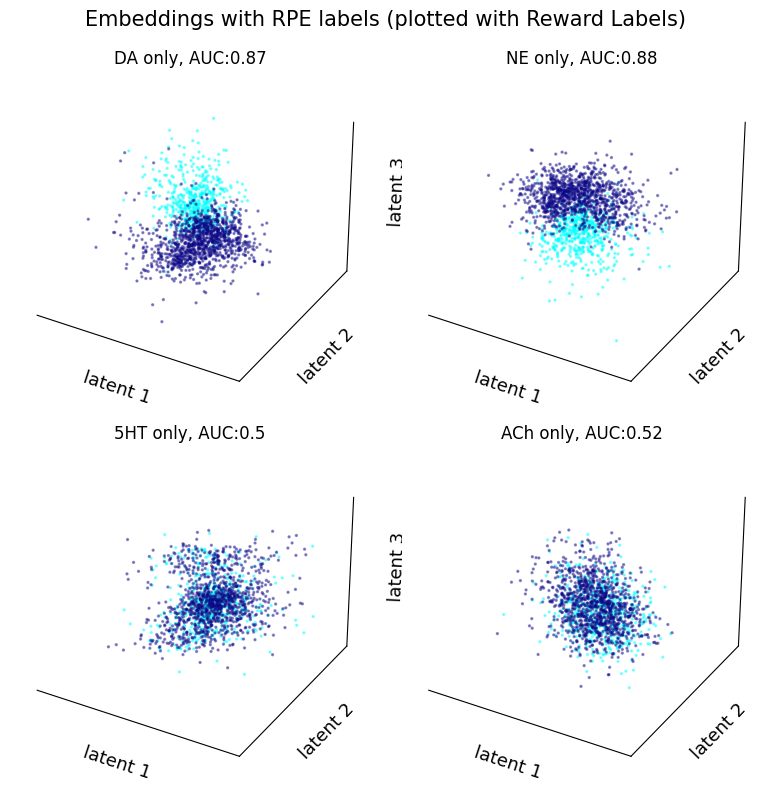

In [39]:
plot4_embeddings(b_embeds, reward_labels, [positive, negative], means=np.round(means,2),t="Embeddings with RPE labels (plotted with Reward Labels)")

# Dimensionality Analysis

The embeddings look 2+ dimensional but we expected something on 1d since RPE is just a 1d value...so let's try and detemrine which is the best embedding dimensionality quantitatively.

In [40]:
# at diff dimensions
dimensions = [1,2,3]
auc_means = []
auc_errors = []
n_iterations = 1


for dimension in dimensions:

    aucs = []

    for i in range(n_iterations):

        # build, train and compute embeddings
        time_embed, behaviour_embed = utils.build_train_compute(formatted_nms,rpe_labels_, d=dimension)

        # get auc
        auc_score, errors = utils.get_auc([time_embed, behaviour_embed], trial_labels=reward_labels)

        # store the value
        aucs.append(auc_score)

    # get the mean and sd for the aucs at that dimension
    auc_means.append(np.mean(aucs))
    auc_errors.append(np.std(aucs))

    print("Finished dimension {}".format(dimension))

pos:  0.4714 neg:  4.4060 total:  4.8774 temperature:  1.0000:  28%|██▊       | 561/2000 [00:15<00:38, 36.94it/s]


KeyboardInterrupt: 

In [ ]:
len(dimensions)

3

Text(0.5, 1.0, 'Effect of Embedding dimension on quality of embeddings made using RPEs ')

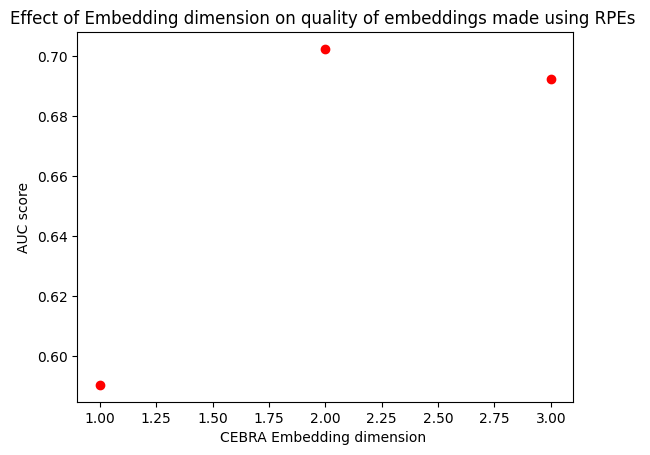

In [ ]:
# plot the auc at each dimensionality
plt.errorbar(x=dimensions, y=auc_means, fmt='ro')
plt.xlabel("CEBRA Embedding dimension ")
plt.ylabel("AUC score")
plt.title("Effect of Embedding dimension on quality of embeddings made using RPEs ")

In [43]:
# get r2 score (x==embedding, y=target/label)
def reconstruction_score(x, y):

    def _linear_fitting(x, y):
        lin_model = sklearn.linear_model.LinearRegression()
        lin_model.fit(x, y)
        return lin_model.score(x, y), lin_model.predict(x)

    return _linear_fitting(x, y)

In [47]:
rpe_labels_.shape

(1717,)

In [46]:
b_embed.shape

(1717, 3)

In [54]:
# get the r2 score
def get_r2(set_of_embeddings, labels, n_iterations=1):

    # list to store mean auc scores at each of these embedding dimensions
    mean_scores = []
    errors = []

    for embedding in set_of_embeddings:

        scores=[]

        for i in range(n_iterations):
            
            # get score
            r2_score, prediction = reconstruction_score(embedding, labels)
            scores.append(r2_score)

        # append score
        mean_scores.append(np.mean(scores))
        errors.append(np.std(scores))


    return np.array(mean_scores), np.array(errors)


In [61]:
r2_scores, r2_errors = get_r2([time_embed, behaviour_embed], rpe_labels_)

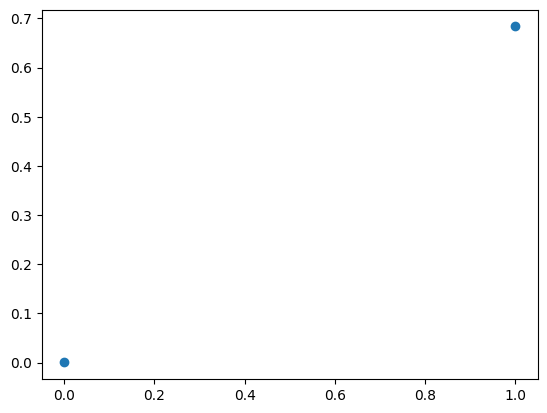

In [62]:
plt.plot(r2_scores,'o')

In [53]:
# now with r2 score

# at diff dimensions
dimensions = [1,2,3,4,5]

for dimension in dimensions:

    r2_scores = []
    r2_scores_t = []


    # build, train and compute embeddings
    time_embed, behaviour_embed = utils.build_train_compute(formatted_nms,rpe_labels_, d=dimension)

    # get auc
    r2_score, errors = reconstruction_score(behaviour_embed, rpe_labels_)
    r2_score_t, errors_t = reconstruction_score(time_embed, rpe_labels_)

    # get the mean and sd for the aucs at that dimension
    r2_scores.append(r2_score)
    r2_scores_t.append(r2_score_t)


    print("Finished dimension {}".format(dimension))


pos:  0.5241 neg:  4.0397 total:  4.5638 temperature:  1.0000: 100%|██████████| 2000/2000 [00:51<00:00, 38.94it/s]
pos:  0.2519 neg:  5.9251 total:  6.1770 temperature:  1.0000: 100%|██████████| 2000/2000 [01:09<00:00, 28.83it/s]
pos:  0.4219 neg:  3.9917 total:  4.4135 temperature:  1.0000: 100%|██████████| 2000/2000 [01:05<00:00, 30.57it/s]
pos:  0.2421 neg:  5.8645 total:  6.1067 temperature:  1.0000: 100%|██████████| 2000/2000 [00:59<00:00, 33.46it/s]
pos:  0.4070 neg:  4.3380 total:  4.7450 temperature:  1.0000: 100%|██████████| 2000/2000 [00:56<00:00, 35.38it/s]
pos:  0.1686 neg:  6.0312 total:  6.1998 temperature:  1.0000:  48%|████▊     | 963/2000 [00:28<00:30, 34.32it/s]


KeyboardInterrupt: 

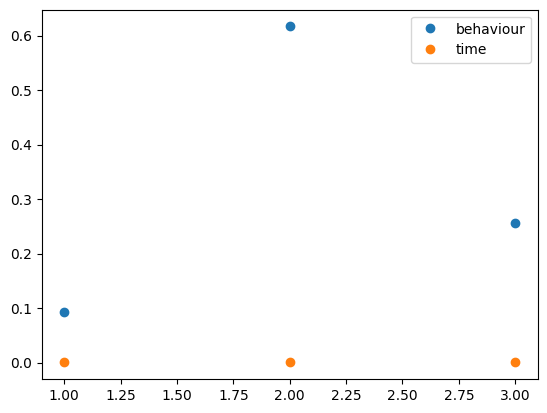

In [52]:
plt.plot(dimensions, r2_scores, 'o', label='behaviour')
plt.plot(dimensions, r2_scores_t, 'o', label='time')
plt.legend()


In [48]:
r2_score

NameError: name 'r2_score' is not defined

In [ ]:
for i in range(0,5):
    print(i)

0
1
2
3
4


In [ ]:
n_choice_trials = np.unique(np.isnan(choice_times),return_counts=True)[1][0]
n_choice_trials

1717